In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import sys

sys.path.append(os.path.abspath("../"))
from dataset import DS_NAMES
from dataset import DS_DIMENSIONS
from utilities.figure_tools import get_latest_results_directory, make_fig_directory, load_results

results_path = "../results/turing/vary_sigma_500t.csv"
output_dir = "./"


In [206]:
all_results = pd.read_csv(results_path).groupby(["explainer", "dataset", "facet_sd"]).mean().reset_index()
# print("explainers:", list(all_results["explainer"].unique()))
# print("datasets", list(all_results["dataset"].unique()))
all_results.head()

,explainer,dataset,facet_sd,n_trees,max_depth,iteration,accuracy,precision,recall,f1,per_valid,avg_dist,avg_length,prep_time,explain_time,sample_time,n_explain
0,FACETIndex,cancer,0.001,500.0,NaN,2.0,0.947368,0.949104,0.900123,0.923632,1.0,0.516507,25.13,150.116931,1.516405,0.075820,20.0
1,FACETIndex,cancer,0.005,500.0,NaN,2.0,0.947368,0.949104,0.900123,0.923632,1.0,0.507295,24.29,151.517626,2.776651,0.138833,20.0
2,FACETIndex,cancer,0.010,500.0,NaN,2.0,0.947368,0.949104,0.900123,0.923632,1.0,0.507983,24.37,151.788192,3.228901,0.161445,20.0
3,FACETIndex,cancer,0.050,500.0,NaN,2.0,0.947368,0.949104,0.900123,0.923632,1.0,0.477761,22.70,144.523454,3.959932,0.197997,20.0
4,FACETIndex,cancer,0.100,500.0,NaN,2.0,0.947368,0.949104,0.900123,0.923632,1.0,0.476110,21.08,133.372126,4.141374,0.207069,20.0


In [207]:
idx = all_results.groupby(["explainer", "dataset"])["avg_dist"].idxmin()
all_results.loc[idx, ["dataset", "facet_sd", "per_valid", "prep_time", "explain_time", "avg_dist", "sample_time"]]

,dataset,facet_sd,per_valid,prep_time,explain_time,avg_dist,sample_time
4,cancer,0.100,1.0,133.372126,4.141374,0.476110,0.207069
11,glass,0.050,1.0,115.173096,0.631351,0.128652,0.031568
16,magic,0.001,1.0,164.730150,0.623305,0.142341,0.031165
26,spambase,0.010,1.0,139.499633,1.398585,0.138050,0.069929
35,vertebral,0.050,1.0,127.301643,0.336492,0.104055,0.016825


In [208]:
df = all_results[["dataset", "facet_sd", "avg_dist"]]
df = df.set_index(["dataset", "facet_sd"])
df = df.stack()
df = df.unstack(level=1)
df.head(20)

,facet_sd,0.001,0.005,0.010,0.050,0.100,0.150,0.200,0.250
dataset,,,,,,,,,
cancer,avg_dist,0.516507,0.507295,0.507983,0.477761,0.476110,0.495935,0.523905,0.548191
glass,avg_dist,0.205420,0.194119,0.178522,0.128652,0.134051,0.149926,0.158328,0.174512
magic,avg_dist,0.142341,0.149214,0.148291,0.156922,0.181303,0.210404,0.230291,0.254358
spambase,avg_dist,0.225645,0.176846,0.138050,0.167910,0.218139,0.253093,0.284963,0.311720
vertebral,avg_dist,0.161312,0.145884,0.135470,0.104055,0.107247,0.115167,0.122417,0.128177


In [209]:
cmap = plt.get_cmap("tab10")
colors = cmap.colors
ds_colors = {
    "cancer": colors[0],
    "glass": colors[1],
    "magic": colors[2],
    "spambase": colors[3],
    "vertebral": colors[4]
}
ds_markers = {
    "cancer": "^",
    "glass": "o",
    "magic": "v",
    "spambase": "s",
    "vertebral": "D"
}
marker_size = 8
line_width = 2
marker_sizes = {
    "cancer": marker_size,
    "glass": marker_size,
    "magic": marker_size,
    "spambase": marker_size,
    "vertebral": marker_size
}

In [210]:
def render_plot(xfeature, yfeature, xlabel, ylabel, title, save_name=None, xrange=None, yrange=None, xlog=False, ylog=False, lloc=None, loc="best", lhorz=False):

    fig = plt.figure(figsize=[6.4, 4.8], frameon=True)
    ax = fig.add_subplot(1, 1, 1)
    for ds in all_results["dataset"].unique():
        is_ds = all_results["dataset"] == ds
        for expl in all_results["explainer"].unique():
            is_expl = all_results["explainer"] == expl
            matching_rows = is_ds & is_expl
            ax.plot(all_results[matching_rows][xfeature], all_results[matching_rows][yfeature], label=ds, lw=line_width, marker=ds_markers[ds], ms=marker_sizes[ds], color=ds_colors[ds])

        # title and axis labels
        if title is not None:
            plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        # legend
        if lhorz:
            plt.legend(loc=loc, ncol=len(all_results["dataset"].unique()), bbox_to_anchor=(0, 1.09, 1, 0), handletextpad=0.5, columnspacing=1, handlelength=1.5)
        else:
            plt.legend(loc=loc)
        # x and y ranges
        if xrange is not None:
            plt.xlim(xrange)
        if yrange is not None:
            plt.ylim(yrange)
        if save_name is not None:
            plt.savefig(output_dir + save_name, bbox_inches="tight")
        # x and y scales
        if ylog:
            plt.yscale('log')
        if xlog:
            plt.xscale('log')
        plt.subplots_adjust(top=1.0)

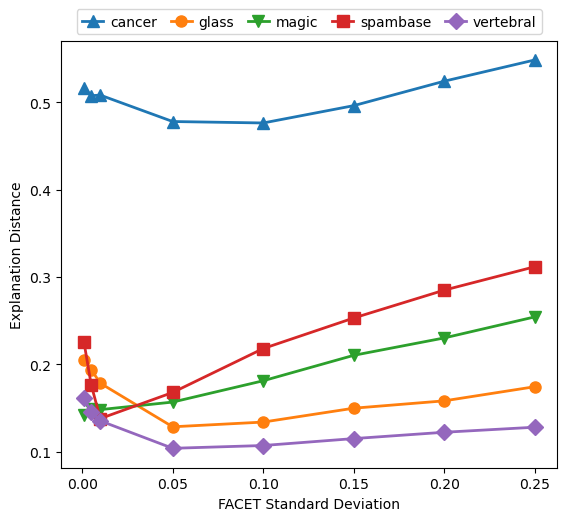

In [211]:
render_plot(xfeature="facet_sd", yfeature="avg_dist", xlabel="FACET Standard Deviation", ylabel="Explanation Distance", title=None, save_name=None, loc="upper center", lhorz=True)

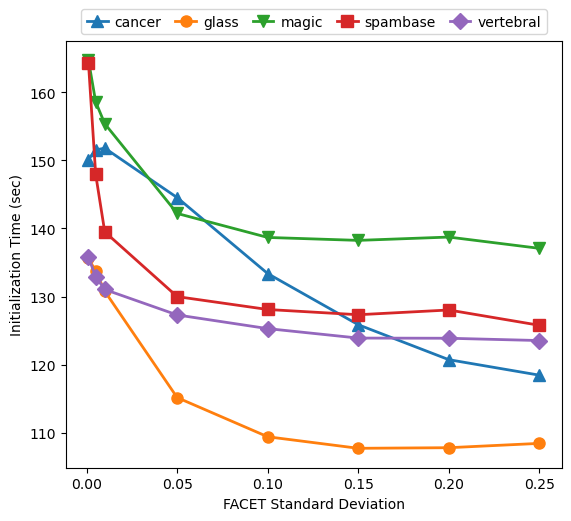

In [212]:
render_plot(xfeature="facet_sd", yfeature="prep_time", xlabel="FACET Standard Deviation", ylabel="Initialization Time (sec)", title=None, save_name=None, loc="upper center", lhorz=True)

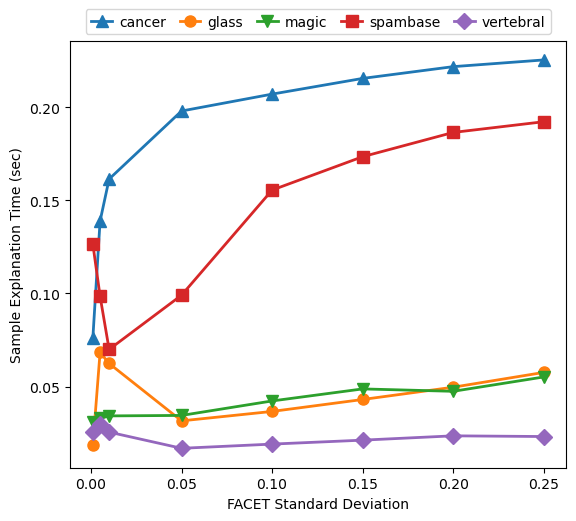

In [213]:
render_plot(xfeature="facet_sd", yfeature="sample_time", xlabel="FACET Standard Deviation", ylabel="Sample Explanation Time (sec)", title=None, save_name=None, loc="upper center", lhorz=True)